In [20]:
from IPython.display import Image

In [21]:
!python sklearn_alone.py

[-11.51292546   4.69457218  -0.45065571]
[-0.89336431 -1.00663819 -1.22409422]
0.00316**2 * RBF(length_scale=109) + WhiteKernel(noise_level=0.637)
0.64**2 * RBF(length_scale=0.365) + WhiteKernel(noise_level=0.294)


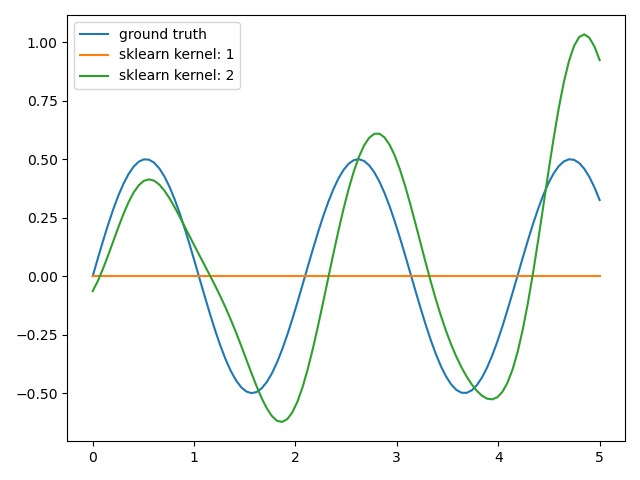

In [22]:
Image(filename='plots/sklearn_kernel.png') 

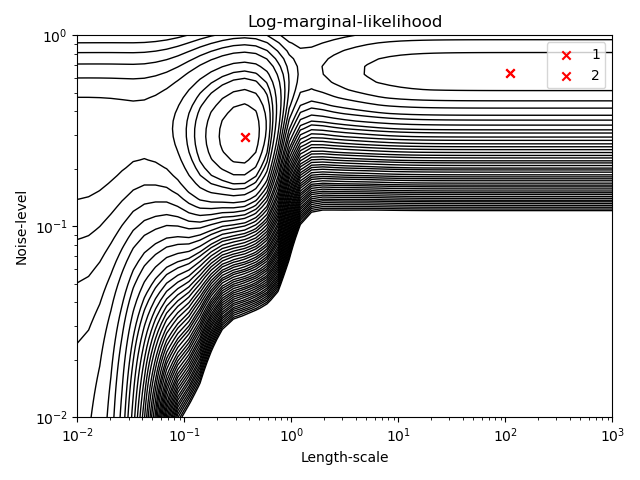

In [32]:
Image(filename='plots/sklearn_lml.png') 

In [33]:
import numpy as np

In [34]:
import matplotlib.pyplot as plt

In [65]:
LML = np.load('data/lml_arr.npy')

In [170]:
!time python sklearn_with_hgdl.py

HGDL -----------------------------------------------------------
23.872337361985007 [ 2.59175473e-05 -6.52379488e-08  7.19403468e-06]
[[0.4092795  0.365446   0.29402389]
 [0.23500082 0.16185455 0.33664958]]
gp - HGDL ( 1 ):  GaussianProcessRegressor(alpha=0.0,
                         kernel=0.64**2 * RBF(length_scale=0.365) + WhiteKernel(noise_level=0.294)) 
kernel: 0.64**2 * RBF(length_scale=0.365) + WhiteKernel(noise_level=0.294)
theta: [-0.89335697 -1.00663674 -1.22409425] [0.4092795  0.365446   0.29402389]
likelihood: -21.80509089012177
gp - HGDL ( 2 ):  GaussianProcessRegressor(alpha=0.0,
                         kernel=0.485**2 * RBF(length_scale=0.162) + WhiteKernel(noise_level=0.337)) 
kernel: 0.485**2 * RBF(length_scale=0.162) + WhiteKernel(noise_level=0.337)
theta: [-1.44816627 -1.82105718 -1.0887127 ] [0.23500082 0.16185455 0.33664958]
likelihood: -22.572531142334473
[[-0.89335697 -1.00663674 -1.22409425]
 [-1.44816627 -1.82105718 -1.0887127 ]]

real	0m6.582s
user	0m16.619s

In [164]:
thetas = np.exp(np.load('data/hgdl_thetas.npy'))

In [165]:
thetas[:,1] = np.exp(np.log(thetas[:,1]))

In [166]:
thetas

array([[0.40927934, 0.36544601, 0.29402395]])

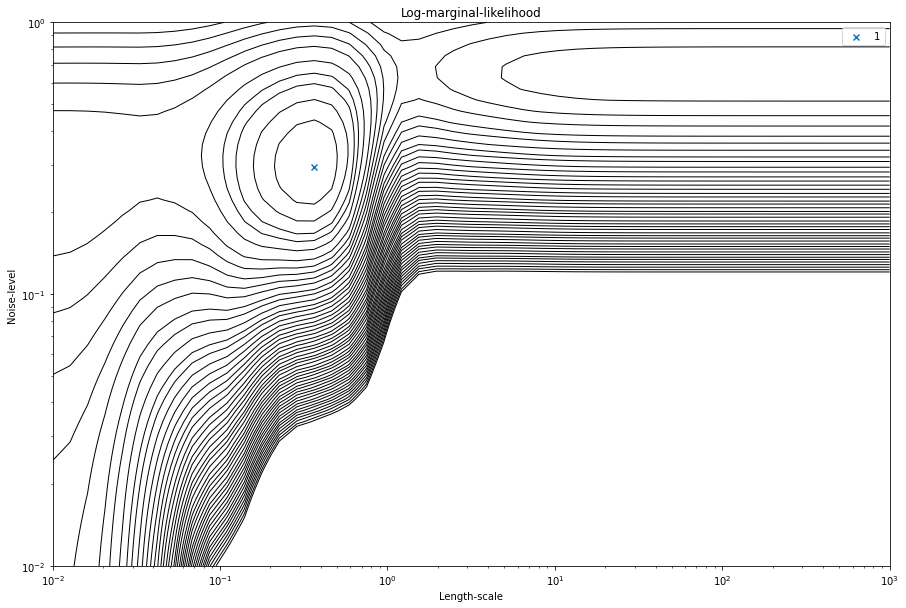

In [167]:
plt.figure(figsize=(15,10))

theta0 = np.logspace(-2, 3, 49)
theta1 = np.logspace(-2, 0, 50)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
from matplotlib.colors import LogNorm

vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
plt.contour(Theta0, Theta1, -LML,
            #levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
            levels=level, colors='black', linewidths=1., norm=LogNorm(vmin=vmin, vmax=vmax))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood");
x, y = thetas[:,1], thetas[:,2]
for i, (pt_x, pt_y) in enumerate(zip(x,y)):
    name = str(i+1)
    plt.scatter(pt_x, pt_y, marker='x', label=name)
#    plt.scatter(x, y, c='red', marker='x', label=name)

    #print(x,y)
plt.legend();